In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim


import random
from pathlib import Path
import torchvision.transforms.functional as TF

import os
import tarfile
import urllib.request
import deeplake
import kagglehub

from typing import Tuple, List, Dict, Callable
from PIL import Image
from tqdm import tqdm



import csv
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/humbug/report.py:47: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # type: ignore
/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.3.1) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

Loading STL-10 Dataset

In [2]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
stl10_train = torchvision.datasets.STL10(root='./stl_data', split='train', download=True, transform=transforms)
stl10_test = torchvision.datasets.STL10(root='./stl_data', split='test', download=True, transform=transforms)

In [3]:
train_size = int(0.9 * len(stl10_train))
val_size = len(stl10_train) - train_size
stl10_train_split, stl10_val_split = random_split(stl10_train, [train_size, val_size])

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

In [5]:
BATCH_SIZE = 64

train_loader = DataLoader(stl10_train_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(stl10_val_split, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader_default = DataLoader(stl10_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Fine-tuning

Loading ResNet-50

In [6]:
resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Fine-tuning ResNet

In [7]:
# REPLACING FINAL LAYER
resnet.fc = torch.nn.Linear(in_features=resnet.fc.in_features, out_features=len(stl10_train.classes), bias=True) 

In [ ]:

# FREEZING BACKBONE
for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(DEVICE)
EPOCHS = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.005)

# FULL FINETUNING
# for param in resnet.parameters():
#     param.requires_grad = True
# optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

In [33]:
resnet_train_accuracies = []
resnet_train_losses = []
resnet_val_accuracies = []
resnet_val_losses = []

for epoch in range(EPOCHS):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100. * correct / total
    avg_train_loss = running_loss / len(train_loader)
    resnet_train_accuracies.append(train_acc)
    resnet_train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}")
    print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    resnet.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100. * correct / total
    avg_val_loss = val_running_loss / len(val_loader)
    resnet_val_accuracies.append(val_acc)
    resnet_val_losses.append(avg_val_loss)
    print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")

Epoch 1
	Training Loss: 0.3745, Train Acc: 90.91%
	Validation Loss: 0.1299, Validation Acc: 96.20%
Epoch 2
	Training Loss: 0.0806, Train Acc: 97.71%
	Validation Loss: 0.1119, Validation Acc: 96.40%
Epoch 3
	Training Loss: 0.0446, Train Acc: 99.09%
	Validation Loss: 0.0908, Validation Acc: 97.00%
Epoch 4
	Training Loss: 0.0314, Train Acc: 99.42%
	Validation Loss: 0.1037, Validation Acc: 96.20%
Epoch 5
	Training Loss: 0.0240, Train Acc: 99.56%
	Validation Loss: 0.1042, Validation Acc: 97.00%


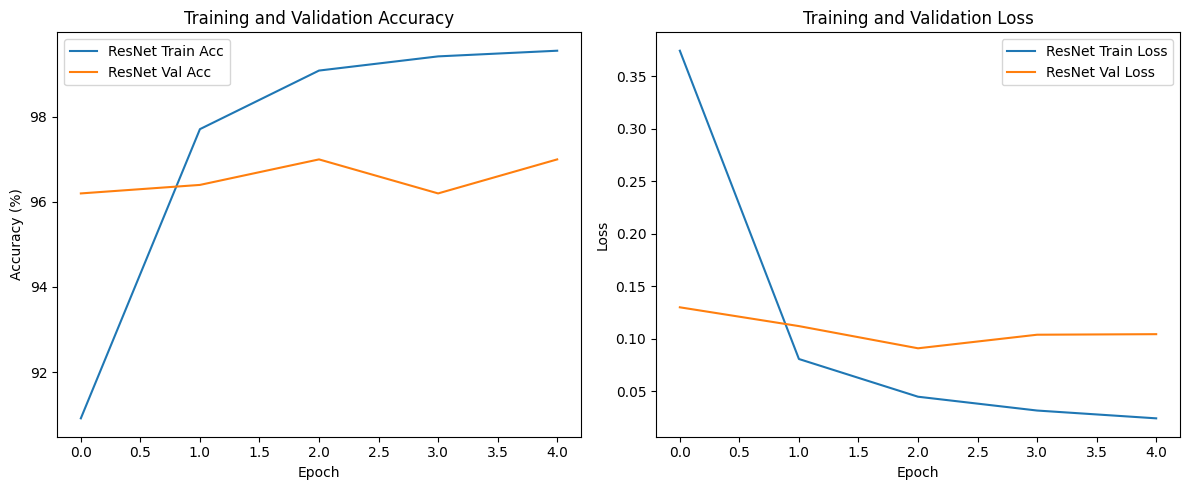

In [42]:
plt.figure(figsize=(12, 5))

# Accuracy curves
plt.subplot(1, 2, 1)
plt.plot(resnet_train_accuracies, label='ResNet Train Acc')
plt.plot(resnet_val_accuracies, label='ResNet Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss curves
plt.subplot(1, 2, 2)
plt.plot(resnet_train_losses, label='ResNet Train Loss')
plt.plot(resnet_val_losses, label='ResNet Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
torch.save(resnet.state_dict(), 'resnet_finetuned.pth')

In [8]:
resnet.load_state_dict(torch.load('resnet_finetuned.pth', map_location=DEVICE))
print("Loaded fine-tuned ResNet-50 weights.")

Loaded fine-tuned ResNet-50 weights.


Loading ViT-S/16

In [9]:
vit = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Fine-tuning ViT

In [10]:
vit.heads.head = torch.nn.Linear(vit.heads.head.in_features, 10)

In [14]:
# Freeze backbone, only train classification head
for param in vit.parameters():
    param.requires_grad = False
for param in vit.heads.head.parameters():
    param.requires_grad = True
    

vit = vit.to(DEVICE)
EPOCHS = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.heads.head.parameters(), lr=0.005)

# FULL FINETUNING
# for param in vit.parameters():
#     param.requires_grad = True
# optimizer = optim.Adam(vit.parameters(), lr=0.0001)

In [39]:
vit_train_accuracies = []
vit_train_losses = []
vit_val_accuracies = []
vit_val_losses = []

for epoch in range(EPOCHS):
    vit.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100. * correct / total
    avg_train_loss = running_loss / len(train_loader)
    vit_train_accuracies.append(train_acc)
    vit_train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}")
    print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    vit.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = vit(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = 100. * correct / total
    avg_val_loss = val_running_loss / len(val_loader)
    vit_val_accuracies.append(val_acc)
    vit_val_losses.append(avg_val_loss)
    print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")

Epoch 1
	Training Loss: 0.2017, Train Acc: 95.09%
	Validation Loss: 0.0547, Validation Acc: 98.40%
Epoch 2
	Training Loss: 0.0270, Train Acc: 99.27%
	Validation Loss: 0.0481, Validation Acc: 98.60%
Epoch 3
	Training Loss: 0.0146, Train Acc: 99.67%
	Validation Loss: 0.0433, Validation Acc: 98.80%
Epoch 4
	Training Loss: 0.0067, Train Acc: 99.98%
	Validation Loss: 0.0418, Validation Acc: 99.00%
Epoch 5
	Training Loss: 0.0041, Train Acc: 100.00%
	Validation Loss: 0.0413, Validation Acc: 99.20%


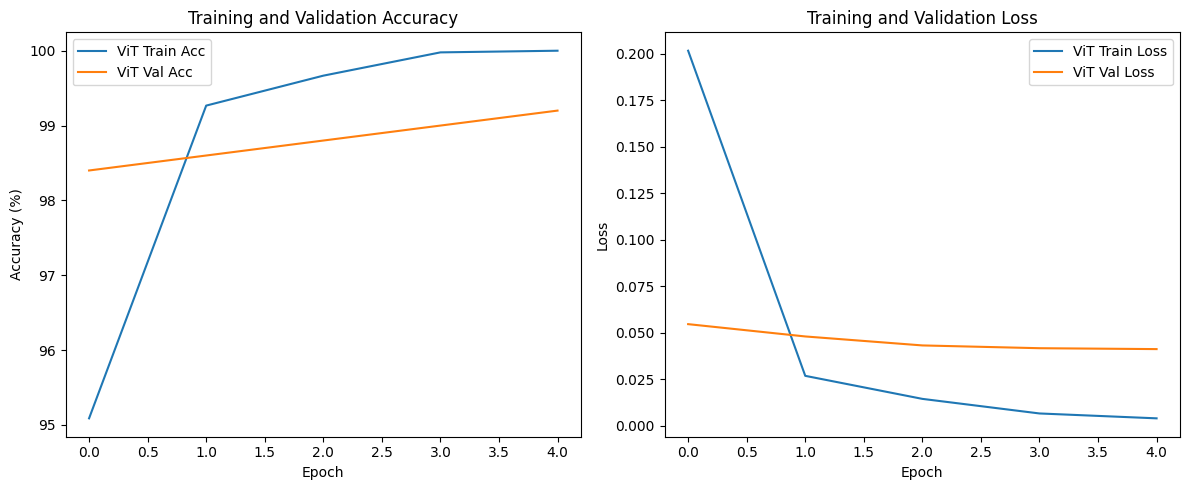

In [43]:
plt.figure(figsize=(12, 5))

# Accuracy curves
plt.subplot(1, 2, 1)
plt.plot(vit_train_accuracies, label='ViT Train Acc')
plt.plot(vit_val_accuracies, label='ViT Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss curves
plt.subplot(1, 2, 2)
plt.plot(vit_train_losses, label='ViT Train Loss')
plt.plot(vit_val_losses, label='ViT Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
torch.save(vit.state_dict(), 'vit_finetuned.pth')

In [11]:
vit.load_state_dict(torch.load('vit_finetuned.pth', map_location=DEVICE))
print("Loaded fine-tuned ViT weights.") 

Loaded fine-tuned ViT weights.


## In-Distribution Performance

Evaluating Fine-Tuned ResNet

In [ ]:
resnet.to(DEVICE)
resnet.eval()
resnet_test_loss = 0.0
resnet_correct = 0
resnet_total = 0

with torch.no_grad():
    for images, labels in test_loader_default:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        resnet_test_loss += loss.item()
        _, predicted = outputs.max(1)
        resnet_total += labels.size(0)
        resnet_correct += predicted.eq(labels).sum().item()

resnet_test_acc = 100. * resnet_correct / resnet_total
resnet_avg_test_loss = resnet_test_loss / len(test_loader_default)
print(f"ResNet-50 correct: {resnet_correct}, total: {resnet_total}")
print(f"ResNet-50 Test Loss: {resnet_avg_test_loss:.4f}, Test Acc: {resnet_test_acc:.2f}%")

ResNet-50 correct: 7738, total: 8000
ResNet-50 Test Loss: 0.1004, Test Acc: 96.72%


Evaluating Fine-Tuned ViT

In [ ]:
vit.to(DEVICE)
vit.eval()
vit_test_loss = 0.0
vit_correct = 0
vit_total = 0

with torch.no_grad():
    for images, labels in test_loader_default:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit(images)
        loss = criterion(outputs, labels)
        vit_test_loss += loss.item()
        _, predicted = outputs.max(1)
        vit_total += labels.size(0)
        vit_correct += predicted.eq(labels).sum().item()

vit_test_acc = 100. * vit_correct / vit_total
vit_avg_test_loss = vit_test_loss / len(test_loader_default)
print(f"ViT-S/16 correct: {vit_correct}, total: {vit_total}")
print(f"ViT-S/16 Test Loss: {vit_avg_test_loss:.4f}, Test Acc: {vit_test_acc:.2f}%")

ViT-S/16 correct: 7881, total: 8000
ViT-S/16 Test Loss: 0.0485, Test Acc: 98.51%


## Color-bias Test

Grayscale Dataset

In [12]:
transforms_grayscale = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
stl10_test_grayscale = torchvision.datasets.STL10(root='./stl_data', split='test', download=True, transform=transforms_grayscale)
test_loader_grayscale = DataLoader(stl10_test_grayscale, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Evaluating Fine-Tuned ResNet

In [ ]:
resnet.eval()
resnet_gray_correct = 0
resnet_gray_total = 0

with torch.no_grad():
    for images, labels in test_loader_grayscale:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(images)
        _, predicted = outputs.max(1)
        resnet_gray_total += labels.size(0)
        resnet_gray_correct += predicted.eq(labels).sum().item()

resnet_gray_acc = 100. * resnet_gray_correct / resnet_gray_total
print(f"ResNet-50 Grayscale Test Acc: {resnet_gray_acc:.2f}%")
print(f"ResNet-50 Accuracy Drop: {resnet_test_acc - resnet_gray_acc:.2f}%")

ResNet-50 Grayscale Test Acc: 92.17%
ResNet-50 Accuracy Drop: 4.55%


Evaluating Fine-Tuned ViT

In [ ]:
vit.eval()
vit_gray_correct = 0
vit_gray_total = 0

with torch.no_grad():
    for images, labels in test_loader_grayscale:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit(images)
        _, predicted = outputs.max(1)
        vit_gray_total += labels.size(0)
        vit_gray_correct += predicted.eq(labels).sum().item()

vit_gray_acc = 100. * vit_gray_correct / vit_gray_total
print(f"ViT-S/16 Grayscale Test Acc: {vit_gray_acc:.2f}%")
print(f"ViT-S/16 Accuracy Drop: {vit_test_acc - vit_gray_acc:.2f}%")

ViT-S/16 Grayscale Test Acc: 96.22%
ViT-S/16 Accuracy Drop: 2.29%


## Shape vs. Texture Bias – Stylized Images

In [25]:
STL10_CLASSES = ["airplane","bird","car","cat","deer","dog","horse","monkey","ship","truck"]

def export_split(split="test", out_root="stl10_export", image_size=224):
    ds = torchvision.datasets.STL10(
        root="./stl_data", split=split, download=True, transform=torchvision.transforms.Resize((image_size, image_size))
    )
    out_root = Path(out_root) / split
    out_root.mkdir(parents=True, exist_ok=True)

    counts = {c: 0 for c in STL10_CLASSES}
    for i in tqdm(range(len(ds)), desc=f"Export {split}"):
        img, y = ds[i]
        cls = STL10_CLASSES[y]
        (out_root/cls).mkdir(parents=True, exist_ok=True)
        img = img.convert("RGB")
        img.save(out_root/cls/f"{counts[cls]:06d}.png")
        counts[cls] += 1


export_split("test",  out_root="stl10_export", image_size=224)

Export test: 100%|██████████| 8000/8000 [01:33<00:00, 85.56it/s]


The dataset was stylised using this repo: https://github.com/rgeirhos/Stylized-ImageNet

In [13]:
STYLISED_PATH = "/home/csalt/Haider/ATML/stylised_dataset/test"
STL10_CLASSES = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]

# Transform for evaluation
stylised_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load stylised dataset
stylised_dataset = torchvision.datasets.ImageFolder(root=STYLISED_PATH,transform=stylised_transform)
stylised_loader = DataLoader(stylised_dataset, batch_size=64, shuffle=True, num_workers=2)

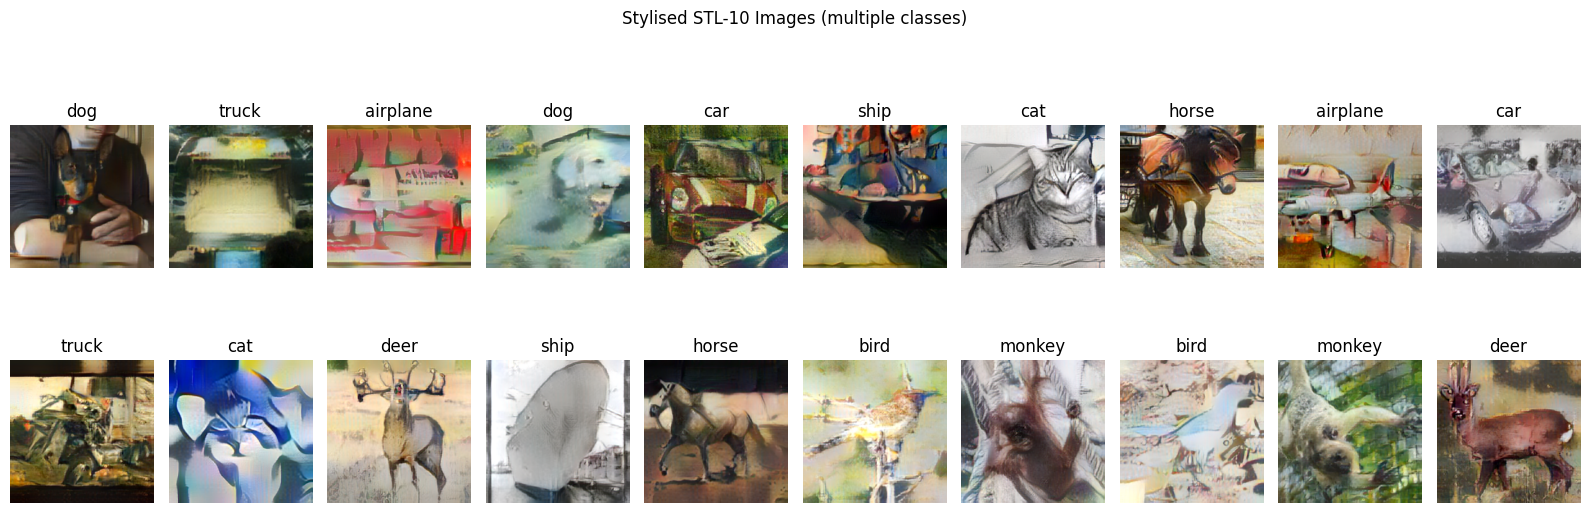

In [20]:
images, labels = next(iter(stylised_loader))

# Denormalize for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
images_vis = images.cpu() * std + mean

# Show up to 2 images per class from the batch
shown = {c: 0 for c in range(len(STL10_CLASSES))}
max_per_class = 2
plt.figure(figsize=(16, 6))
plot_idx = 1
for i in range(images_vis.size(0)):
    label = labels[i].item()
    if shown[label] < max_per_class:
        img = images_vis[i].permute(1, 2, 0).numpy().clip(0, 1)
        label_name = STL10_CLASSES[label]
        plt.subplot(2, len(STL10_CLASSES), plot_idx)
        plt.imshow(img)
        plt.title(label_name)
        plt.axis('off')
        shown[label] += 1
        plot_idx += 1
plt.suptitle("Stylised STL-10 Images (multiple classes)")
plt.tight_layout()
plt.show()

Evaluating ResNet

In [22]:
resnet.to(DEVICE)
resnet.eval()
# Evaluate ResNet
resnet_correct_cue_conflict = 0
resnet_total_cue_conflict = 0
resnet_shape_correct = 0

with torch.no_grad():
    for images, labels in stylised_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(images)
        _, preds = outputs.max(1)
        resnet_total_cue_conflict += labels.size(0)
        resnet_correct_cue_conflict += preds.eq(labels).sum().item()
        resnet_shape_correct += preds.eq(labels).sum().item()

resnet_shape_accuracy = 100. * resnet_shape_correct / resnet_total_cue_conflict
print(f"ResNet-50 Stylised Accuracy: {resnet_shape_accuracy:.2f}%")
resnet_shape_bias = (resnet_correct_cue_conflict / resnet_correct) * 100
print(f"ResNet-50 Shape Bias: {resnet_shape_bias:.2f}")

ResNet-50 Stylised Accuracy: 41.39%
ResNet-50 Shape Bias: 42.79


Evaluating ViT

In [23]:
vit.to(DEVICE)
vit.eval()
vit_correct_cue_conflict = 0
vit_total_cue_conflict = 0
vit_shape_correct = 0

with torch.no_grad():
    for images, labels in stylised_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit(images)
        _, preds = outputs.max(1)
        vit_total_cue_conflict += labels.size(0)
        vit_correct_cue_conflict += preds.eq(labels).sum().item()
        # Shape bias: count predictions matching the shape label (folder/class index)
        vit_shape_correct += preds.eq(labels).sum().item()

vit_shape_accuracy = 100. * vit_shape_correct / vit_total_cue_conflict
print(f"ViT-B/16 Stylised Accuracy: {vit_shape_accuracy:.2f}%")
vit_shape_bias = (vit_correct_cue_conflict / vit_correct) * 100
print(f"ViT-B/16 Shape Bias: {vit_shape_bias:.2f}")

ViT-B/16 Stylised Accuracy: 77.50%
ViT-B/16 Shape Bias: 78.66


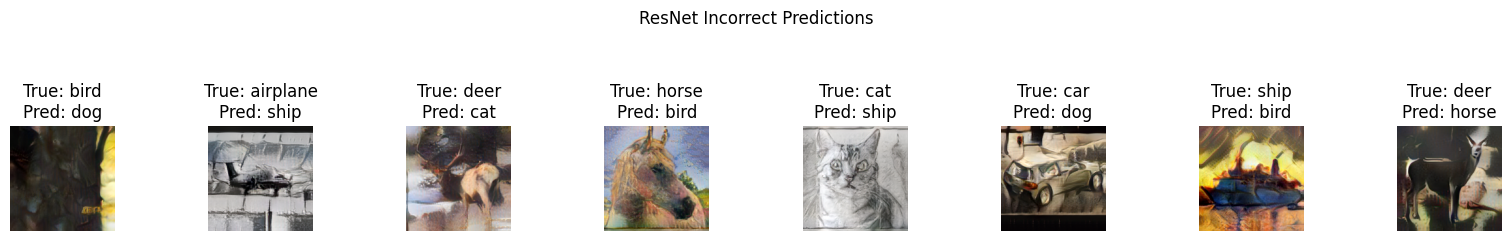

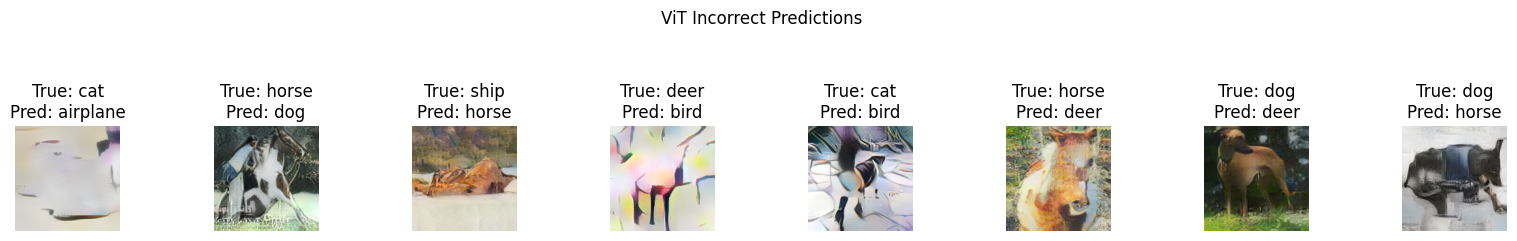

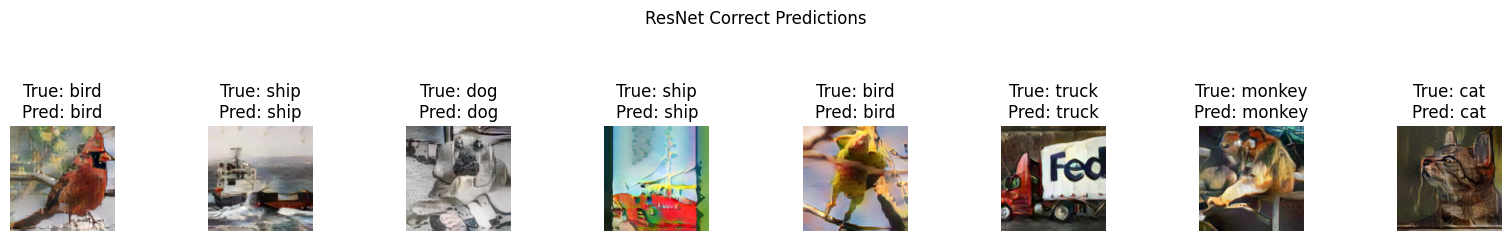

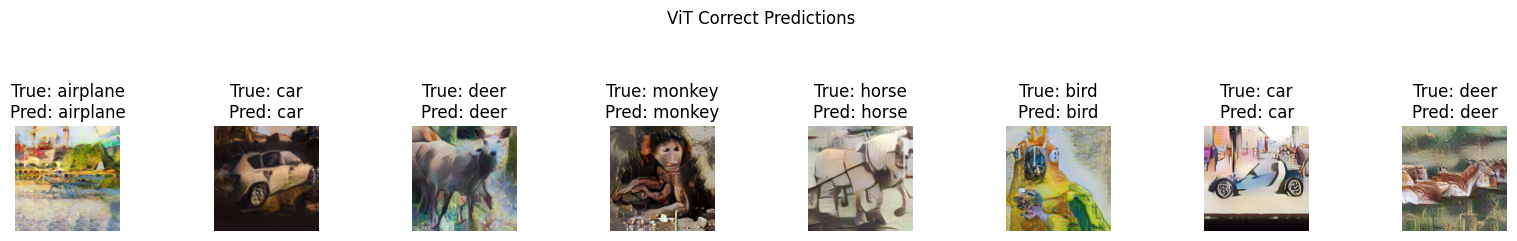

In [24]:
def get_predictions(model, dataloader, device):
    model.eval()
    all_images, all_labels, all_preds = [], [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_images.append(images.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
    images = torch.cat(all_images)
    labels = torch.cat(all_labels)
    preds = torch.cat(all_preds)
    return images, labels, preds
import random

def show_examples(images, labels, preds, class_names, correct=True, n=8, title=""):
    mask = (labels == preds) if correct else (labels != preds)
    idxs = torch.where(mask)[0]
    if len(idxs) == 0:
        print("No examples to show.")
        return
    idxs = idxs.tolist()
    random.shuffle(idxs)
    idxs = idxs[:n]
    plt.figure(figsize=(16, 2))
    for i, idx in enumerate(idxs):
        img = images[idx] * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        img = img.permute(1,2,0).numpy().clip(0,1)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {class_names[labels[idx]]}\nPred: {class_names[preds[idx]]}")
    plt.suptitle(title, y=1.18)
    plt.tight_layout()
    plt.show()

class_names = STL10_CLASSES
resnet_images, resnet_labels, resnet_preds = get_predictions(resnet, stylised_loader, DEVICE)
vit_images, vit_labels, vit_preds = get_predictions(vit, stylised_loader, DEVICE)

show_examples(resnet_images, resnet_labels, resnet_preds, class_names, correct=False, n=8, title="ResNet Incorrect Predictions")
show_examples(vit_images, vit_labels, vit_preds, class_names, correct=False, n=8, title="ViT Incorrect Predictions")

show_examples(resnet_images, resnet_labels, resnet_preds, class_names, correct=True, n=8, title="ResNet Correct Predictions")
show_examples(vit_images, vit_labels, vit_preds, class_names, correct=True, n=8, title="ViT Correct Predictions")

## Translation Invariance Test

Translated Dataset

In [14]:
SHIFT_PIXELS = 30

DIRECTIONS = {
    "up": (0, -SHIFT_PIXELS),
    "down": (0, SHIFT_PIXELS),
    "left": (-SHIFT_PIXELS, 0),
    "right": (SHIFT_PIXELS, 0),
    "up_left": (-SHIFT_PIXELS, -SHIFT_PIXELS),
    "up_right": (SHIFT_PIXELS, -SHIFT_PIXELS),
    "down_left": (-SHIFT_PIXELS, SHIFT_PIXELS),
    "down_right": (SHIFT_PIXELS, SHIFT_PIXELS),
}

def make_shift_transform_affine(dx: int, dy: int, fill=0):
    """
    PIL -> resize -> affine translate -> tensor -> normalize
    """
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(224),
        torchvision.transforms.Lambda(lambda img: torchvision.transforms.functional.affine(
            img,
            angle=0,
            translate=(dx, dy), 
            scale=1.0,
            shear=0.0,
            fill=fill
        )),
            
        torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

class RollShiftTransform:
    """
    PIL -> resize -> tensor -> torch.roll (circular shift) -> normalize
    No padding borders (wrap-around).
    """
    def __init__(self, dx: int, dy: int):
        self.dx, self.dy = dx, dy
        self._resize = torchvision.transforms.Resize((224, 224), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
        self._to_tensor = torchvision.transforms.ToTensor()
        self._norm = torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

    def __call__(self, img_pil):
        img_pil = self._resize(img_pil)
        x = self._to_tensor(img_pil)            # [C, H, W]
        x = torch.roll(x, shifts=(self.dy, self.dx), dims=(1, 2))
        x = self._norm(x)
        return x


class RandomShiftSTL10(torchvision.datasets.STL10):
    """
    Each sample is shifted by a random direction from DIRECTIONS.
    mode='affine' -> padding borders (fill)
    mode='roll'   -> circular wrap-around (no borders)
    """
    def __init__(self, root, split, download, directions, fill=0, mode='affine'):
        super().__init__(root=root, split=split, download=download, transform=None)
        assert mode in ('affine', 'roll')
        self.directions = list(directions.items())  # [(name, (dx,dy)), ...]
        self.fill = fill
        self.mode = mode

    def __getitem__(self, index):
        img, target = super().__getitem__(index)   # img is PIL
        name, (dx, dy) = random.choice(self.directions)

        if self.mode == 'affine':
            x = make_shift_transform_affine(dx, dy, fill=self.fill)(img)
        else:
            x = RollShiftTransform(dx, dy)(img)

        return x, target, name

def get_mixed_shift_loader(split="test", batch_size=BATCH_SIZE, fill=0, seed=None, mode='affine'):
    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)
    ds = RandomShiftSTL10(root="./stl_data", split=split, download=True,
                          directions=DIRECTIONS, fill=fill, mode=mode)
    return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2)


# shifted_loader = get_mixed_shift_loader(split="test", seed=1337, mode='affine', fill=0)
shifted_loader  = get_mixed_shift_loader(split="test", seed=1337, mode='roll')

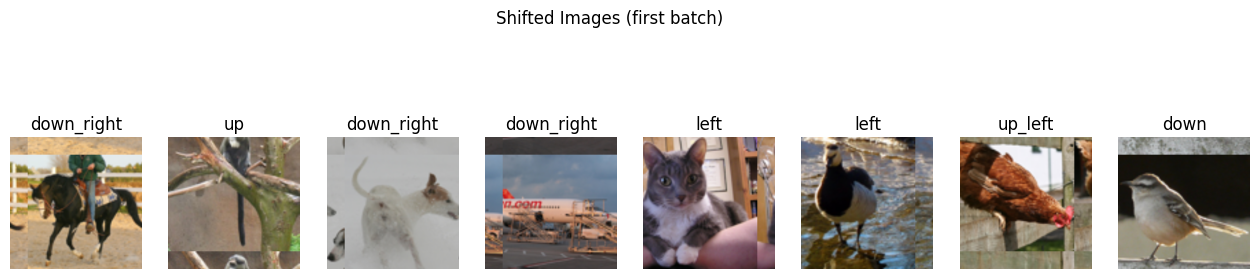

In [ ]:
images, labels, directions = next(iter(shifted_loader))

# Move images to CPU and denormalize for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

images_vis = images[:8].cpu() * std + mean  # Take first 8 images

plt.figure(figsize=(16, 4))
for i in range(8):
    img = images_vis[i].permute(1, 2, 0).numpy()
    img = img.clip(0, 1)
    plt.subplot(1, 8, i + 1)
    plt.imshow(img)
    plt.title(directions[i])
    plt.axis('off')
plt.suptitle("Shifted Images (first batch)")
plt.show()

Evaluating ResNet

In [63]:
resnet.eval()
resnet_shift_correct = 0
resnet_shift_total = 0

with torch.no_grad():
    for images, labels, direction in shifted_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(images)
        _, predicted = outputs.max(1)
        resnet_shift_total += labels.size(0)
        resnet_shift_correct += predicted.eq(labels).sum().item()

resnet_shift_acc = 100. * resnet_shift_correct / resnet_shift_total
print(f"ResNet-50 Shifted Test Acc: {resnet_shift_acc:.2f}%")

ResNet-50 Shifted Test Acc: 96.04%


Evaluating ViT

In [64]:
vit.eval()
vit_shift_correct = 0
vit_shift_total = 0

with torch.no_grad():
    for images, labels, direction in shifted_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit(images)
        _, predicted = outputs.max(1)
        vit_shift_total += labels.size(0)
        vit_shift_correct += predicted.eq(labels).sum().item()

vit_shift_acc = 100. * vit_shift_correct / vit_shift_total
print(f"ViT-S/16 Shifted Test Acc: {vit_shift_acc:.2f}%")

ViT-S/16 Shifted Test Acc: 97.85%


## Permutation Test

In [15]:
def _check_divisible(H: int, W: int, patch_size: int):
    assert H % patch_size == 0 and W % patch_size == 0, \
        f"Image size {H}x{W} must be divisible by patch_size={patch_size}."

def _grid_shape(H: int, W: int, patch_size: int) -> Tuple[int, int]:
    _check_divisible(H, W, patch_size)
    return H // patch_size, W // patch_size

def _tensor_to_patches(x: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    x: [C,H,W] (already 224x224)
    returns patches: [C, nH, nW, p, p]
    """
    C, H, W = x.shape
    nH, nW = _grid_shape(H, W, patch_size)
    # use unfold for robust slicing
    patches = x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    # patches shape: [C, nH, nW, p, p]
    return patches

def _patches_to_tensor(patches: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    patches: [C, nH, nW, p, p] -> x: [C, H, W]
    """
    C, nH, nW, p, _ = patches.shape
    H, W = nH * p, nW * p
    out = torch.empty((C, H, W), dtype=patches.dtype, device=patches.device)
    for i in range(nH):
        for j in range(nW):
            out[:, i*p:(i+1)*p, j*p:(j+1)*p] = patches[:, i, j]
    return out

class PatchShuffleSTL10(torchvision.datasets.STL10):
    """
    Disrupt global structure by shuffling patch positions on a fixed grid.
    Each sample uses a fresh random permutation (set seed for reproducibility).
    """
    def __init__(self, root="./stl_data", split="test", download=True,
                 patch_size: int = 32):
        super().__init__(root=root, split=split, download=download, transform=None)
        self.patch_size = patch_size
        self.base_tfm = torchvision.transforms.Compose([
            torchvision.transforms.Resize(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])

    def __getitem__(self, index):
        img, target = super().__getitem__(index)       # PIL
        x = self.base_tfm(img)                         # [C,224,224]
        patches = _tensor_to_patches(x, self.patch_size)  # [C,nH,nW,p,p]
        C, nH, nW, p, _ = patches.shape

        # Flatten grid indices, permute, then place back row-major
        idxs = list(range(nH * nW))
        random.shuffle(idxs)
        shuffled = torch.empty_like(patches)
        for new_flat, old_flat in enumerate(idxs):
            ni, nj = divmod(new_flat, nW)
            oi, oj = divmod(old_flat, nW)
            shuffled[:, ni, nj] = patches[:, oi, oj]

        out = _patches_to_tensor(shuffled, self.patch_size)  # [C,224,224]
        return out, target


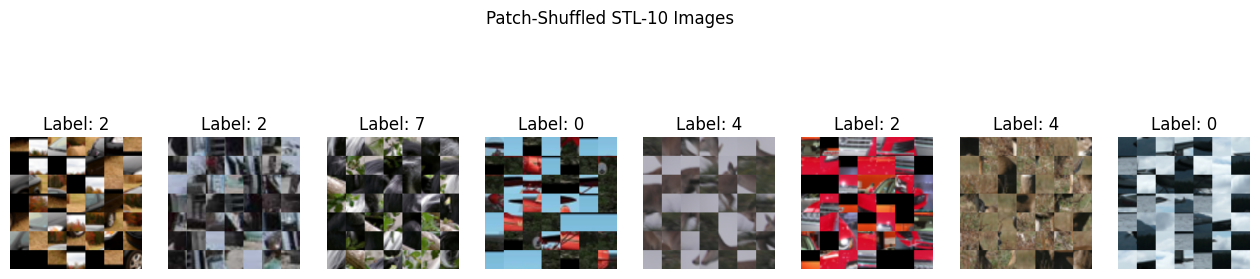

In [16]:
patch_shuffle_dataset = PatchShuffleSTL10(root="./stl_data", split="test", download=True, patch_size=32)
patch_shuffle_loader = DataLoader(patch_shuffle_dataset, batch_size=8, shuffle=True, num_workers=2)

images, labels = next(iter(patch_shuffle_loader))

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
images_vis = images * std + mean

plt.figure(figsize=(16, 4))
for i in range(images_vis.size(0)):
    img = images_vis[i].permute(1, 2, 0).numpy().clip(0, 1)
    plt.subplot(1, images_vis.size(0), i + 1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Patch-Shuffled STL-10 Images")
plt.show()

Evaluating ResNet

In [20]:
resnet.to(DEVICE)
resnet.eval()
resnet_patch_shuffled_correct = 0
resnet_patch_shuffled_total = 0

with torch.no_grad():
    for images, labels in patch_shuffle_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(images)
        _, predicted = outputs.max(1)
        resnet_patch_shuffled_total += labels.size(0)
        resnet_patch_shuffled_correct += predicted.eq(labels).sum().item()

resnet_patch_shuffled_acc = 100. * resnet_patch_shuffled_correct / resnet_patch_shuffled_total
print(f"ResNet-50 Patch Shuffled Test Acc: {resnet_patch_shuffled_acc:.2f}%")

ResNet-50 Patch Shuffled Test Acc: 74.15%


Evaluating ViT

In [22]:
vit.to(DEVICE)
vit.eval()
vit_patch_shuffled__correct = 0
vit_patch_shuffled__total = 0

with torch.no_grad():
    for images, labels in patch_shuffle_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit(images)
        _, predicted = outputs.max(1)
        vit_patch_shuffled__total += labels.size(0)
        vit_patch_shuffled__correct += predicted.eq(labels).sum().item()

vit_patch_shuffled__acc = 100. * vit_patch_shuffled__correct / vit_patch_shuffled__total
print(f"ViT-S/16 Patch Shuffled Test Acc: {vit_patch_shuffled__acc:.2f}%")

ViT-S/16 Patch Shuffled Test Acc: 83.95%


## Occlusion Test

In [17]:
class PatchOcclusionRandomSTL10(torchvision.datasets.STL10):
    def __init__(self, root="./stl_data", split="test", download=True,
                 patch_size: int = 32, num_patches_to_mask: int = 12,
                 fill_mode: str = "black"):
        super().__init__(root=root, split=split, download=download, transform=None)
        self.patch_size = patch_size
        self.num_mask = num_patches_to_mask
        self.fill_mode = fill_mode
        self._resize_to_tensor = torchvision.transforms.Compose([
            torchvision.transforms.Resize(224),
            torchvision.transforms.ToTensor()
        ])
        self._norm = torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

    def __getitem__(self, index):
        img, target = super().__getitem__(index)  # PIL

        if self.fill_mode == "black":
            x = self._resize_to_tensor(img)       # [C,224,224] in [0,1]
            patches = _tensor_to_patches(x, self.patch_size)
            C, nH, nW, p, _ = patches.shape
            K = min(self.num_mask, nH * nW)
            coords = random.sample(range(nH * nW), K)
            black_tensor = torch.zeros((C, p, p), dtype=x.dtype, device=x.device)
            for flat in coords:
                i, j = divmod(flat, nW)
                patches[:, i, j] = black_tensor
            out = _patches_to_tensor(patches, self.patch_size)
            out = self._norm(out)

        elif self.fill_mode == "zeros":
            x = self._resize_to_tensor(img)
            x = self._norm(x)
            patches = _tensor_to_patches(x, self.patch_size)
            C, nH, nW, p, _ = patches.shape
            K = min(self.num_mask, nH * nW)
            coords = random.sample(range(nH * nW), K)
            for flat in coords:
                i, j = divmod(flat, nW)
                patches[:, i, j] = 0.0
            out = _patches_to_tensor(patches, self.patch_size)

        elif self.fill_mode == "mean":
            x = self._resize_to_tensor(img)
            patches = _tensor_to_patches(x, self.patch_size)
            C, nH, nW, p, _ = patches.shape
            K = min(self.num_mask, nH * nW)
            coords = random.sample(range(nH * nW), K)
            mean_tensor = torch.tensor([0.485,0.456,0.406], dtype=x.dtype, device=x.device).view(3,1,1)
            for flat in coords:
                i, j = divmod(flat, nW)
                patches[:, i, j] = mean_tensor
            out = _patches_to_tensor(patches, self.patch_size)
            out = self._norm(out)
        else:
            raise ValueError("fill_mode must be 'black', 'zeros' or 'mean'")

        return out, target

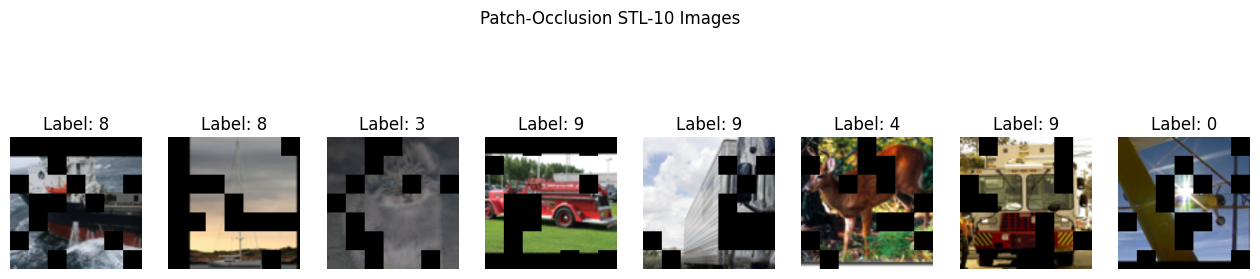

In [18]:
patch_occlusion_dataset = PatchOcclusionRandomSTL10(root="./stl_data", split="test", download=True, patch_size=32)
patch_occlusion_loader = DataLoader(patch_occlusion_dataset, batch_size=8, shuffle=True, num_workers=2)

images, labels = next(iter(patch_occlusion_loader))

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
images_vis = images * std + mean

plt.figure(figsize=(16, 4))
for i in range(images_vis.size(0)):
    img = images_vis[i].permute(1, 2, 0).numpy().clip(0, 1)
    plt.subplot(1, images_vis.size(0), i + 1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Patch-Occlusion STL-10 Images")
plt.show()

Evaluating ResNet

In [32]:
resnet.to(DEVICE)
resnet.eval()
resnet_patch_occlusion_correct = 0
resnet_patch_occlusion_total = 0

with torch.no_grad():
    for images, labels in patch_occlusion_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(images)
        _, predicted = outputs.max(1)
        resnet_patch_occlusion_total += labels.size(0)
        resnet_patch_occlusion_correct += predicted.eq(labels).sum().item()

resnet_patch_occlusion_acc = 100. * resnet_patch_occlusion_correct / resnet_patch_occlusion_total
print(f"ResNet-50 Patch Occlusion Test Acc: {resnet_patch_occlusion_acc:.2f}%")

ResNet-50 Patch Occlusion Test Acc: 90.92%


Evaluating ViT

In [33]:
vit.to(DEVICE)
vit.eval()
vit_patch_occlusion__correct = 0
vit_patch_occlusion__total = 0

with torch.no_grad():
    for images, labels in patch_shuffle_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit(images)
        _, predicted = outputs.max(1)
        vit_patch_occlusion__total += labels.size(0)
        vit_patch_occlusion__correct += predicted.eq(labels).sum().item()

vit_patch_occlusion__acc = 100. * vit_patch_occlusion__correct / vit_patch_occlusion__total
print(f"ViT-S/16 Patch Occlusion Test Acc: {vit_patch_occlusion__acc:.2f}%")

ViT-S/16 Patch Occlusion Test Acc: 84.05%


## Feature Representation Analysis

In [33]:
class PenultimateHook:
    """Capture the input to a final Linear layer (penultimate embedding)."""
    def __init__(self, linear_module: nn.Linear):
        self.features = []
        def pre_hook(module, inputs):
            # inputs is a tuple; inputs[0] is [N, D] tensor
            x = inputs[0].detach()
            # flatten in case some nets pass [N, D, 1, 1]
            self.features.append(x.view(x.size(0), -1).cpu())
        self.handle = linear_module.register_forward_pre_hook(pre_hook)

    def clear(self):
        self.features = []

    def close(self):
        self.handle.remove()

    def stacked_numpy(self):
        return torch.cat(self.features, dim=0).numpy()

def get_resnet_linear(model: nn.Module) -> nn.Linear:
    # torchvision ResNet has .fc
    assert isinstance(model.fc, nn.Linear), "Expected resnet.fc to be Linear"
    return model.fc

def get_vit_linear(model: nn.Module) -> nn.Linear:
    """
    Variants across torchvision versions:
      - model.heads.head (common)
      - model.heads (nn.Sequential) with single Linear
      - model.head (older)
      - model.classifier (fallback)
    """
    # try common path
    if hasattr(model, "heads"):
        heads = model.heads
        if isinstance(heads, nn.Sequential) and len(heads) == 1 and isinstance(heads[0], nn.Linear):
            return heads[0]
        if hasattr(heads, "head") and isinstance(heads.head, nn.Linear):
            return heads.head
    # fallbacks
    if hasattr(model, "head") and isinstance(model.head, nn.Linear):
        return model.head
    if hasattr(model, "classifier") and isinstance(model.classifier, nn.Linear):
        return model.classifier
    raise RuntimeError("Could not locate ViT final Linear layer to hook.")


@torch.no_grad()
def _first_two(batch):
    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
        return batch[0], batch[1]
    raise ValueError("Loader must yield at least (images, labels).")


@torch.no_grad()
def extract_with_hook(model, hook: PenultimateHook, loader, domain_name):
    feats, labels, domains = [], [], []
    hook.clear()
    for batch in tqdm(loader, desc=f"feats [{domain_name}]"):
        x, y = _first_two(batch)
        x = x.to(DEVICE, non_blocking=True)
        _ = model(x)  # run full forward; hook captures penultimate
        labels.append(y.cpu())
        domains += [domain_name] * x.size(0)
    feats = hook.stacked_numpy()
    labels = torch.cat(labels, 0).numpy()
    domains = np.array(domains)
    return feats, labels, domains


def reduce_2d(X, method="tsne", seed=42, perp=30, pca_dim=50):
    if method.lower() == "pca":
        Z = PCA(n_components=2, random_state=seed).fit_transform(X)
        return Z, "PCA"
    Xp = PCA(n_components=min(pca_dim, X.shape[1])).fit_transform(X)
    Z = TSNE(n_components=2, perplexity=perp, init="pca",
             random_state=seed, learning_rate="auto").fit_transform(Xp)
    return Z, f"t-SNE (perp={perp})"

def plot_side_by_side(Z_res, y_res, d_res, Z_vit, y_vit, d_vit,
                      class_names, domain_names, title, out_path=None, max_points_per_class=1200):
    plt.figure(figsize=(18, 10))
    cmap = plt.cm.get_cmap("tab10", len(class_names))
    markers = ["o","s","^","D","v","P","X","*","<",">"]
    marker_map = {d: markers[i % len(markers)] for i, d in enumerate(domain_names)}

    for ax_i, (Z, y, d, model_name) in enumerate([
        (Z_res, y_res, d_res, "ResNet-50"),
        (Z_vit, y_vit, d_vit, "ViT-B/16"),
    ]):
        ax = plt.subplot(1, 2, ax_i + 1)
        y = np.asarray(y); d = np.asarray(d)
        # subsample per class
        keep_idx = []
        for c in np.unique(y):
            idx_c = np.where(y == c)[0]
            if max_points_per_class and len(idx_c) > max_points_per_class:
                idx_c = np.random.choice(idx_c, size=max_points_per_class, replace=False)
            keep_idx.append(idx_c)
        if keep_idx:
            keep_idx = np.concatenate(keep_idx)
            Z, y, d = Z[keep_idx], y[keep_idx], d[keep_idx]

        for c in np.unique(y):
            for dom in domain_names:
                mask = (y == c) & (d == dom)
                if not np.any(mask): continue
                ax.scatter(Z[mask, 0], Z[mask, 1],
                           c=[cmap(c)], marker=marker_map[dom],
                           s=12, alpha=0.7, linewidths=0)
        ax.set_title(model_name)
        ax.set_xticks([]); ax.set_yticks([])

    from matplotlib.lines import Line2D
    handles_colors = [Line2D([0],[0], marker='o', color='w',
                             markerfacecolor=cmap(i), markersize=10,
                             label=class_names[i]) for i in range(len(class_names))]
    handles_markers = [Line2D([0],[0], marker=marker_map[d], color='k',
                              linestyle='', markersize=10, label=d) for d in domain_names]

    plt.figlegend(handles_colors, [cn for cn in class_names], loc="upper center", ncol=len(class_names), fontsize=8)
    plt.figlegend(handles_markers, domain_names, loc="lower center", ncol=len(domain_names), fontsize=9)
    # plt.suptitle(title, fontsize=14) 
    plt.tight_layout(rect=[0, 0.06, 1, 0.9])
    if out_path:
        plt.savefig(out_path, dpi=200)
        print(f"Saved {out_path}")
    plt.show()

# ----------------------------
# Public entrypoint
# ----------------------------
def run_embedding_plot_with_hooks(loaders_dict,
                                  method="tsne", tsne_perp=35, seed=42,
                                  max_points_per_class=1200, resnet=None, vit=None, out_path="embeddings_side_by_side.png",):
    """
    loaders_dict: {"normal": test_loader_default, "grayscale": test_loader_grayscale, ...}
    """
    assert isinstance(loaders_dict, dict) and len(loaders_dict) >= 1

    # Register hooks on final linear layers (capture penultimate embeddings)
    res_fc = get_resnet_linear(resnet)
    vit_fc = get_vit_linear(vit)
    res_hook = PenultimateHook(res_fc)
    vit_hook = PenultimateHook(vit_fc)

    try:
        # Collect embeddings
        Xr_list, Yr_list, Dr_list = [], [], []
        Xv_list, Yv_list, Dv_list = [], [], []
        for name, loader in loaders_dict.items():
            fr, yr, dr = extract_with_hook(resnet, res_hook, loader, name)
            fv, yv, dv = extract_with_hook(vit,    vit_hook, loader, name)
            Xr_list.append(fr); Yr_list.append(yr); Dr_list.append(dr)
            Xv_list.append(fv); Yv_list.append(yv); Dv_list.append(dv)

        Xr = np.concatenate(Xr_list, 0); Yr = np.concatenate(Yr_list, 0); Dr = np.concatenate(Dr_list, 0)
        Xv = np.concatenate(Xv_list, 0); Yv = np.concatenate(Yv_list, 0); Dv = np.concatenate(Dv_list, 0)

        # Reduce
        Zr, _ = reduce_2d(Xr, method=method, seed=seed, perp=tsne_perp)
        Zv, _ = reduce_2d(Xv, method=method, seed=seed, perp=tsne_perp)

        # Plot
        plot_side_by_side(Zr, Yr, Dr, Zv, Yv, Dv,
                          class_names=STL10_CLASSES,
                          domain_names=list(loaders_dict.keys()),
                          title=f"ResNet vs ViT embeddings → {method.upper()}",
                          out_path=out_path,
                          max_points_per_class=max_points_per_class)
    finally:
        # Always remove hooks
        res_hook.close()
        vit_hook.close()

feats [stylized]: 100%|██████████| 125/125 [00:10<00:00, 11.99it/s]
/tmp/ipykernel_4132203/2072058644.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(class_names))


Saved embeds_resnet_vit_side_by_side.png


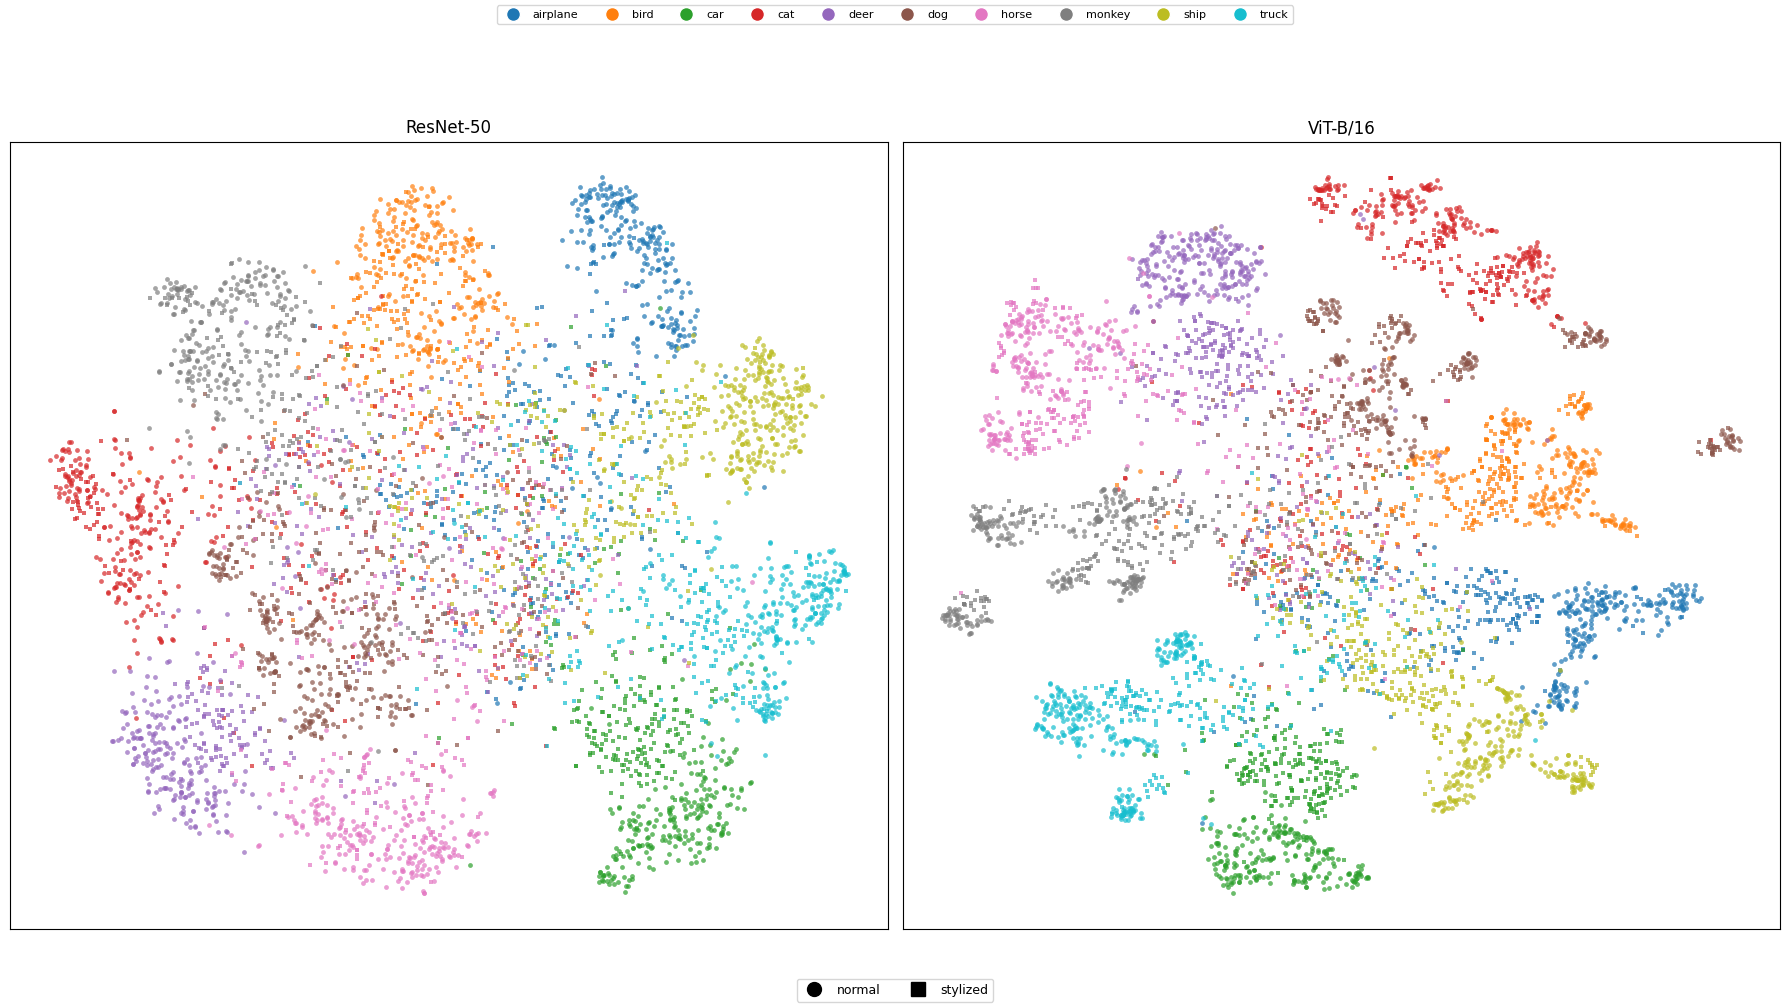

In [35]:
loaders = {
    "normal":      test_loader_default,
    # "grayscale":   test_loader_grayscale,
    "stylized":    stylised_loader,
    # "shifted":     shifted_loader,
    # "patch_shuf":  patch_shuffle_loader,
    # "patch_occ":   patch_occlusion_loader,
}

run_embedding_plot_with_hooks(
    loaders_dict=loaders,
    method="tsne",       
    tsne_perp=35,
    seed=42,
    max_points_per_class=500,
    resnet=resnet,
    vit=vit,
    out_path="embeds_resnet_vit_side_by_side.png"
)

## Domain Generalization Test on PACS

In [3]:
DIR_PHOTO = '/home/csalt/Haider/ATML/Homework3-PACS/PACS/photo'
DIR_ART = '/home/csalt/Haider/ATML/Homework3-PACS/PACS/art_painting'
DIR_CARTOON = '/home/csalt/Haider/ATML/Homework3-PACS/PACS/cartoon'
DIR_SKETCH = '/home/csalt/Haider/ATML/Homework3-PACS/PACS/sketch'

# Prepare Pytorch train/test Dataset`s
photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH)

# Check dataset sizes
print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os

class PACSDataset(Dataset):
    """
    Custom Dataset for PACS domain generalization.
    Args:
        root_dir (str): Root directory containing PACS domains.
        domains (list): List of domain names to include (e.g., ['photo', 'art_painting', 'cartoon']).
        transform (callable, optional): Transform to apply to images.
    """
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        # PACS has 7 classes
        self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        # Collect image paths and labels
        for domain in domains:
            domain_dir = os.path.join(root_dir, domain)
            for class_name in os.listdir(domain_dir):
                if class_name in self.classes:
                    class_dir = os.path.join(domain_dir, class_name)
                    for img_name in os.listdir(class_dir):
                        if img_name.endswith('.jpg') or img_name.endswith('.png'):
                            self.samples.append((
                                os.path.join(class_dir, img_name),
                                self.class_to_idx[class_name]
                            ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
train_domains = ['photo', 'art_painting', 'cartoon']
test_domain = ['sketch']

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


pacs_train = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=train_domains,
    transform=transform
)
pacs_test = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=test_domain,
    transform=transform
)

In [6]:
# # Split training data into train and validation
train_size = int(0.9 * len(pacs_train))
val_size = len(pacs_train) - train_size
pacs_train_split, pacs_val_split = random_split(pacs_train, [train_size, val_size])

# # Create data loaders
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

pacs_train_loader = DataLoader(pacs_train_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
pacs_val_loader = DataLoader(pacs_val_split, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
pacs_test_loader = DataLoader(pacs_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training on {len(pacs_train_split)} images from domains: {', '.join(train_domains)}")
print(f"Validating on {len(pacs_val_split)} images from domains: {', '.join(train_domains)}")
print(f"Testing on {len(pacs_test)} images from domain: {', '.join(test_domain)}")

Training on 5455 images from domains: photo, art_painting, cartoon
Validating on 607 images from domains: photo, art_painting, cartoon
Testing on 3929 images from domain: sketch


In [7]:
# Training function
def train_model(model, dataloader, criterion, optimizer, epochs=5):
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        avg_train_loss = running_loss / len(dataloader)
        train_accuracies.append(train_acc)
        train_losses.append(avg_train_loss)
        
        print(f"Epoch {epoch+1}")
        print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in pacs_val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        avg_val_loss = val_running_loss / len(pacs_val_loader)
        val_accuracies.append(val_acc)
        val_losses.append(avg_val_loss)
        
        print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    
    return train_accuracies, train_losses, val_accuracies, val_losses


In [15]:
resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
resnet_pacs.fc = torch.nn.Linear(resnet_pacs.fc.in_features, len(pacs_train.classes))

# # Freeze backbone, only train the last layer
# for param in resnet_pacs.parameters():
#     param.requires_grad = False
# for param in resnet_pacs.fc.parameters():
#     param.requires_grad = True

resnet_pacs = resnet_pacs.to(DEVICE)
resnet_pacs_criterion = torch.nn.CrossEntropyLoss()
# resnet_pacs_optimizer = optim.Adam(resnet_pacs.fc.parameters(), lr=0.005)
resnet_pacs_optimizer = optim.Adam(resnet_pacs.parameters(), lr=0.001)

In [16]:
print("Fine-tuning ResNet-50 on PACS dataset...")
resnet_pacs_train_acc, resnet_pacs_train_loss, resnet_pacs_val_acc, resnet_pacs_val_loss = train_model(
    model=resnet_pacs,
    dataloader=pacs_train_loader,
    criterion=resnet_pacs_criterion,
    optimizer=resnet_pacs_optimizer,
    epochs=5
)

Fine-tuning ResNet-50 on PACS dataset...
Epoch 1
	Training Loss: 0.6519, Train Acc: 78.74%
	Validation Loss: 1.5506, Validation Acc: 66.89%
Epoch 2
	Training Loss: 0.3337, Train Acc: 88.76%
	Validation Loss: 0.7369, Validation Acc: 77.10%
Epoch 3
	Training Loss: 0.2100, Train Acc: 92.94%
	Validation Loss: 0.4822, Validation Acc: 82.87%
Epoch 4
	Training Loss: 0.1797, Train Acc: 94.28%
	Validation Loss: 0.4002, Validation Acc: 88.14%
Epoch 5
	Training Loss: 0.1283, Train Acc: 95.80%
	Validation Loss: 0.7158, Validation Acc: 82.04%


In [17]:
# Evaluate ResNet on Sketch domain
resnet_pacs.eval()
resnet_sketch_correct = 0
resnet_sketch_total = 0

with torch.no_grad():
    for images, labels in pacs_test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = resnet_pacs(images)
        _, predicted = outputs.max(1)
        resnet_sketch_total += labels.size(0)
        resnet_sketch_correct += predicted.eq(labels).sum().item()

resnet_sketch_acc = 100. * resnet_sketch_correct / resnet_sketch_total
print(f"ResNet-50 Sketch Domain Acc: {resnet_sketch_acc:.2f}%")

ResNet-50 Sketch Domain Acc: 53.14%


In [18]:
# Fine-tune ViT for PACS
vit_pacs = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)
vit_pacs.heads.head = torch.nn.Linear(vit_pacs.heads.head.in_features, len(pacs_train.classes))

# Freeze backbone, only train classification head
# for param in vit_pacs.parameters():
#     param.requires_grad = False
# for param in vit_pacs.heads.head.parameters():
#     param.requires_grad = True
    
vit_pacs = vit_pacs.to(DEVICE)
vit_pacs_criterion = torch.nn.CrossEntropyLoss()
# vit_pacs_optimizer = optim.Adam(vit_pacs.heads.head.parameters(), lr=0.005)
vit_pacs_optimizer = optim.Adam(vit_pacs.heads.parameters(), lr=0.005)

In [19]:
# Train ViT on PACS
print("Fine-tuning ViT-B/16 on PACS dataset...")
vit_pacs_train_acc, vit_pacs_train_loss, vit_pacs_val_acc, vit_pacs_val_loss = train_model(
    model=vit_pacs,
    dataloader=pacs_train_loader,
    criterion=vit_pacs_criterion,
    optimizer=vit_pacs_optimizer,
    epochs=5
)

Fine-tuning ViT-B/16 on PACS dataset...
Epoch 1
	Training Loss: 0.3101, Train Acc: 89.70%
	Validation Loss: 0.1985, Validation Acc: 92.75%
Epoch 2
	Training Loss: 0.1174, Train Acc: 96.37%
	Validation Loss: 0.1756, Validation Acc: 93.90%
Epoch 3
	Training Loss: 0.0734, Train Acc: 98.08%
	Validation Loss: 0.1671, Validation Acc: 94.56%
Epoch 4
	Training Loss: 0.0528, Train Acc: 98.68%
	Validation Loss: 0.2110, Validation Acc: 93.08%
Epoch 5
	Training Loss: 0.0369, Train Acc: 99.32%
	Validation Loss: 0.1750, Validation Acc: 94.40%


In [20]:
# Evaluate ViT on Sketch domain
vit_pacs.eval()
vit_sketch_correct = 0
vit_sketch_total = 0

with torch.no_grad():
    for images, labels in pacs_test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = vit_pacs(images)
        _, predicted = outputs.max(1)
        vit_sketch_total += labels.size(0)
        vit_sketch_correct += predicted.eq(labels).sum().item()

vit_sketch_acc = 100. * vit_sketch_correct / vit_sketch_total
print(f"ViT-B/16 Sketch Domain Acc: {vit_sketch_acc:.2f}%")


ViT-B/16 Sketch Domain Acc: 46.12%


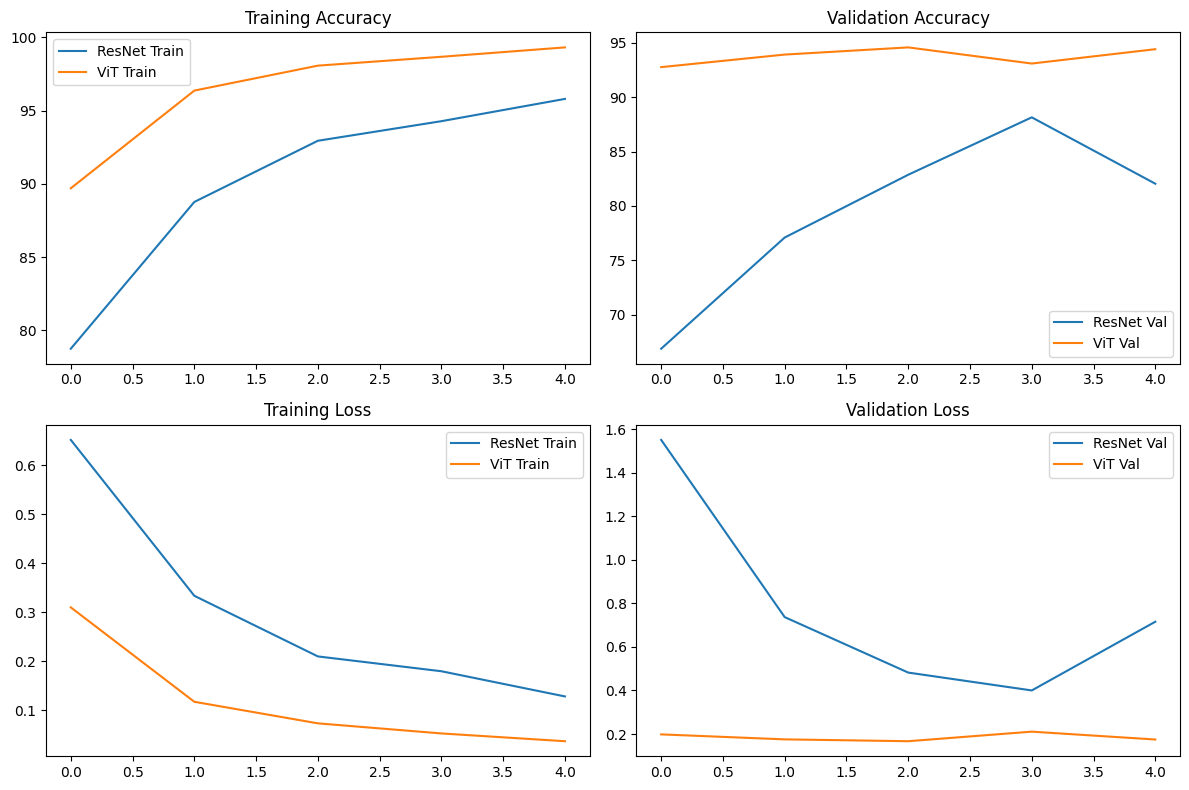


Final Domain Generalization Results:
ResNet-50: Sketch Domain Accuracy: 53.14%
ViT-B/16: Sketch Domain Accuracy: 46.12%


In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(resnet_pacs_train_acc, label='ResNet Train')
plt.plot(vit_pacs_train_acc, label='ViT Train')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(resnet_pacs_val_acc, label='ResNet Val')
plt.plot(vit_pacs_val_acc, label='ViT Val')
plt.title('Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(resnet_pacs_train_loss, label='ResNet Train')
plt.plot(vit_pacs_train_loss, label='ViT Train')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(resnet_pacs_val_loss, label='ResNet Val')
plt.plot(vit_pacs_val_loss, label='ViT Val')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print final results
print("\nFinal Domain Generalization Results:")
print(f"ResNet-50: Sketch Domain Accuracy: {resnet_sketch_acc:.2f}%")
print(f"ViT-B/16: Sketch Domain Accuracy: {vit_sketch_acc:.2f}%")

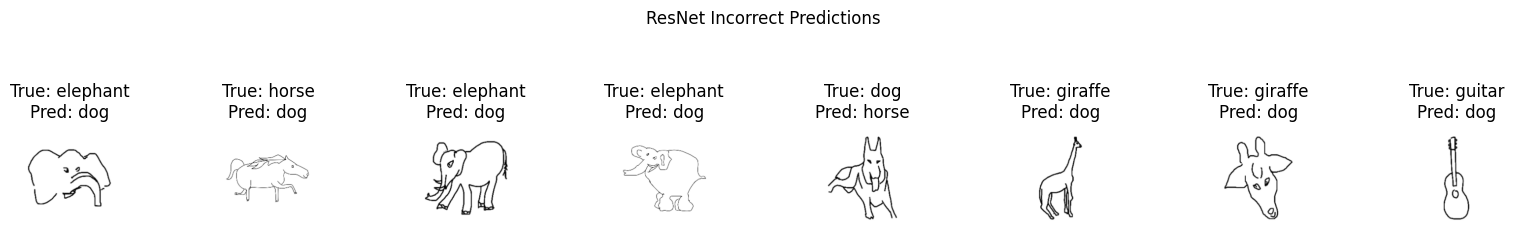

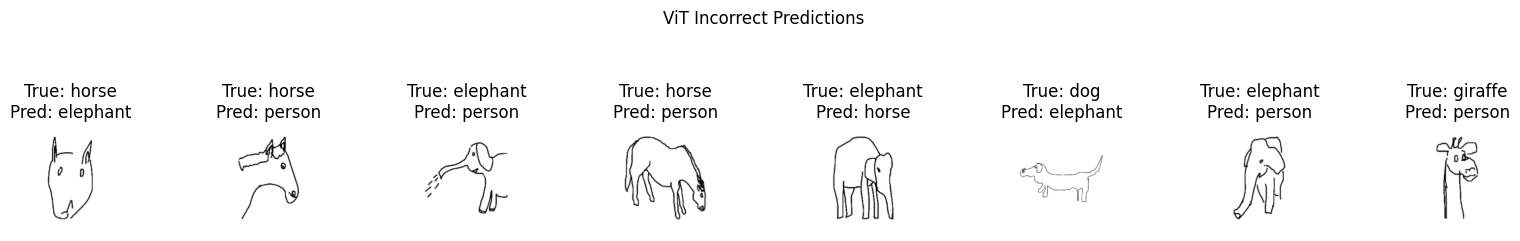

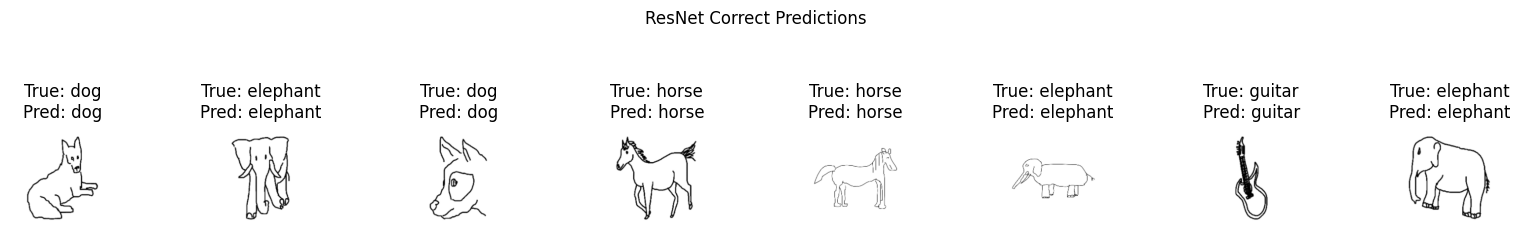

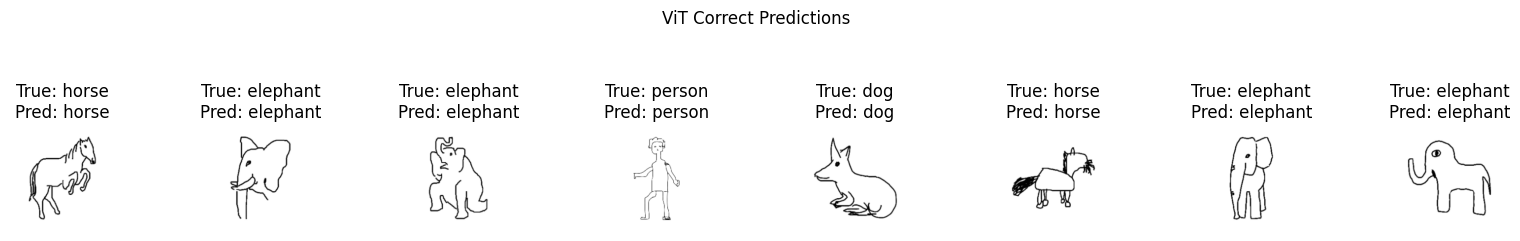

In [ ]:
class_names = pacs_train.classes if hasattr(pacs_train, 'classes') else ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

# Get predictions for ResNet
resnet_images, resnet_labels, resnet_preds = get_predictions(resnet_pacs, pacs_test_loader, DEVICE)
# Get predictions for ViT
vit_images, vit_labels, vit_preds = get_predictions(vit_pacs, pacs_test_loader, DEVICE)

# Show incorrect predictions
show_examples(resnet_images, resnet_labels, resnet_preds, class_names, correct=False, n=8, title="ResNet Incorrect Predictions")
show_examples(vit_images, vit_labels, vit_preds, class_names, correct=False, n=8, title="ViT Incorrect Predictions")

# Show correct predictions
show_examples(resnet_images, resnet_labels, resnet_preds, class_names, correct=True, n=8, title="ResNet Correct Predictions")
show_examples(vit_images, vit_labels, vit_preds, class_names, correct=True, n=8, title="ViT Correct Predictions")